<a href="https://colab.research.google.com/github/alasarerhan/Deep-Learning-Projects/blob/main/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Classification

# Imports

In [1]:
import keras
import tensorflow as tf

In [2]:
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers,metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Accuracy,AUC

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Functions

In [3]:
def get_image_paths(root_dir, num_images=None):
  all_images = []
  for extension in ['*.jpg', '*.jpeg', '*.png']:
    all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
  if num_images is None:
    return all_images
  else:
    return random.sample(all_images, min(num_images, len(all_images)))

def display_images(img_list):
  plt.figure(figsize=(15, 6))
  for i, img_path in enumerate(img_list):
    img = image.load_img(img_path)
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2,5, i + 1)
    plt.imshow(img.squeeze())
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Data Understanding

In [4]:
dir_path = '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification'

In [5]:
img_list = get_image_paths(dir_path)
print(len(img_list))

2537


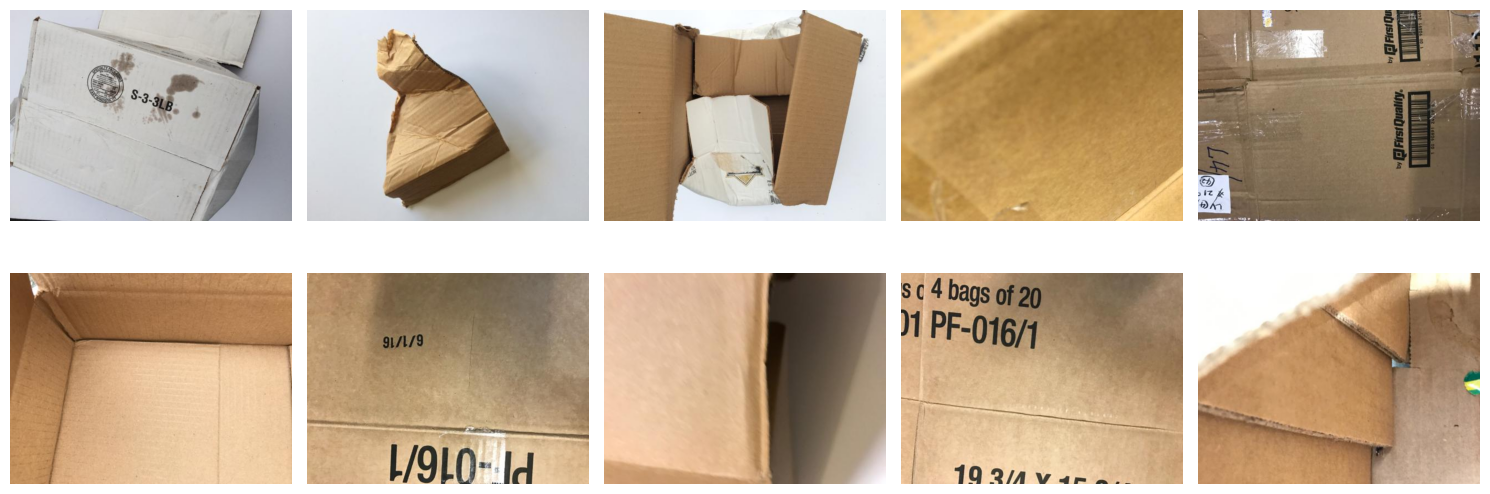

In [6]:
display_images(img_list[:10])

# Data Augmentation

In [7]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1, #kesme dönüşümü
                           zoom_range = 0.1,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

val = ImageDataGenerator(rescale=1/255,
                         validation_split=0.1)

In [8]:
train_generator = train.flow_from_directory(dir_path,
                                            target_size = (224,224),
                                            batch_size=32,
                                            class_mode = 'categorical', # creates a one hot encoded vector for all classes
                                            subset = 'training')

val_generator = val.flow_from_directory(dir_path,
                                        target_size = (224,224),
                                        batch_size=251,
                                        class_mode = 'categorical',
                                        subset = 'validation')

Found 2285 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


In [9]:
train_images, train_labels = next(train_generator)
print("First 5 labels from the training set:")
print(train_labels[:5])

First 5 labels from the training set:
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


# Model

In [10]:

model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

metrics = ['accuracy',
           AUC(name='auc', multi_label=True)]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience = 10,
                               verbose = 1,
                               restore_best_weights = True)

model_checkpoint = ModelCheckpoint(filepath = 'garbage_model.keras',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   save_weights_only = False,
                                   verbose = 1)

# Training

In [11]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 50,
                    callbacks = [early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print(f"Total training duration: {total_duration}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2638 - auc: 0.5980 - loss: 1.8410 
Epoch 1: val_loss improved from inf to 1.55749, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1458s 18s/step - accuracy: 0.2646 - auc: 0.5987 - loss: 1.8383 - val_accuracy: 0.3452 - val_auc: 0.7261 - val_loss: 1.5575
Epoch 2/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.3696 - auc: 0.7344 - loss: 1.4368
Epoch 2: val_loss improved from 1.55749 to 1.41519, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 494ms/step - accuracy: 0.3704 - auc: 0.7350 - loss: 1.4361 - val_accuracy: 0.4206 - val_auc: 0.7749 - val_loss: 1.4152
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4706 - auc: 0.8025 - loss: 1.3079
Epoch 3: val_loss improved from 1.41519 to 1.29816, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 479ms/step - accuracy: 0.4709 - auc: 0.8026 - loss: 1.3076 - val_accuracy: 0.4841 - val_auc: 0.8271 - val_loss: 1.2982
Ep

# Model Performance

In [12]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

  # Loss
  plt.figure(figsize=(10,5))
  plt.plot(history.history[train_loss], label='Training Loss')
  plt.plot(history.history[val_loss], label='Validation Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Metrics
  plt.figure(figsize=(10,5))
  plt.plot(history.history[train_metric], label=f"Training:{train_metric}")
  plt.plot(history.history[val_metric], label=f"Validation:{val_metric}")
  plt.title(f'Training and Validation {train_metric} Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel(f'train_metric')
  plt.legend()
  plt.show()

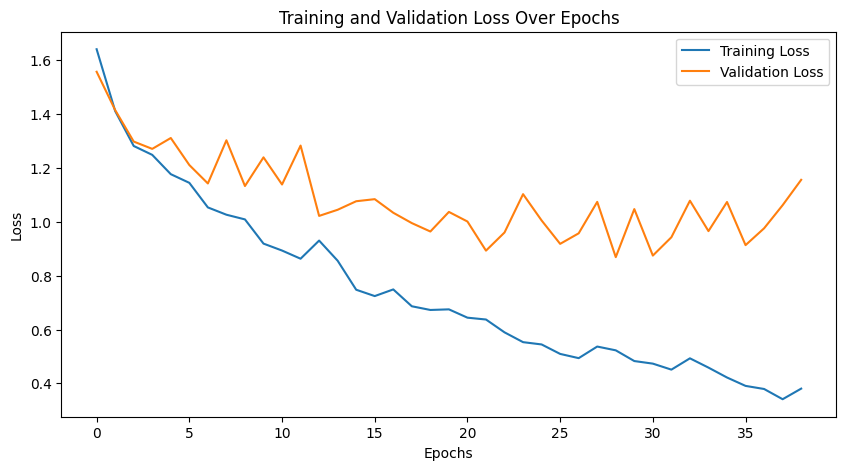

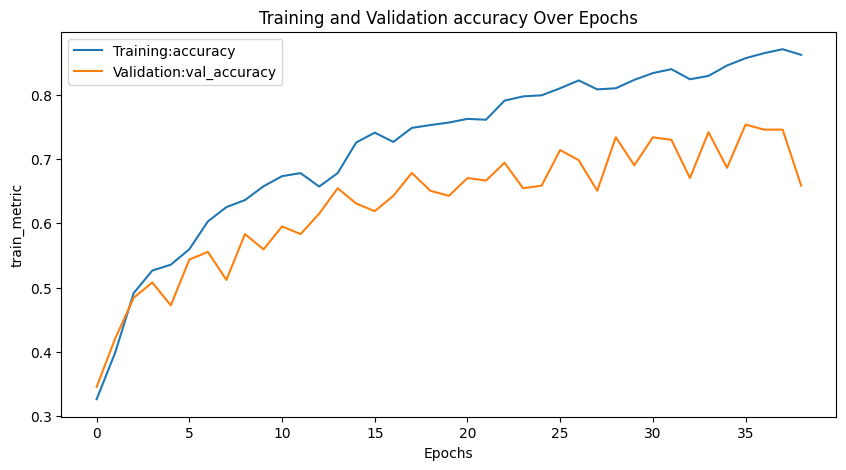

In [13]:
 plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

# Model Performance Numeric

In [15]:
val_loss, val_accuracy, val_auc = model.evaluate(val_generator, verbose = 0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")


Validation Loss: 0.8688619136810303
Validation Accuracy: 0.7341269850730896
Validation AUC: 0.9255132079124451


# Prediction

In [16]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [27]:
im_dir = "/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification"

In [28]:
images_paths = [im_dir + "/metal/metal10.jpg", im_dir + "/glass/glass104.jpg", im_dir + "/plastic/plastic100.jpg",im_dir + "/paper/paper11.jpg", im_dir + "/cardboard/cardboard12.jpg", im_dir + "/trash/trash23.jpg"]

In [17]:
garbage_model = load_model("/content/garbage_model.keras")

In [18]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size = target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

In [19]:
def prediction_probs(img_array, model, waste_labels):
  predictions = model.predict(img_array, verbose = 0)
  predicted_class_idx = np.argmax(predictions[0])
  predicted_class = waste_labels.get(predicted_class_idx, "Unknown")
  max_probability = np.max(predictions[0])
  return max_probability, predicted_class

In [32]:
def display_images(image_paths, model, waste_labels):
  # dynamic display
  num_images = len(image_paths)
  num_cols = 4
  num_rows = (num_images + num_cols - 1) // num_cols
  plt.figure(figsize = (num_cols * 5, num_rows * 5))

  for i, path in enumerate(image_paths):
    img, img_array = preprocess_image(path)
    probability, predicted_class = prediction_probs(img_array, model, waste_labels)
    ax = plt.subplot(num_rows, num_cols, i + 1)
    img = image.img_to_array(img)
    plt.imshow(img.astype('uint8'))
    plt.title(f"Max Probability: {probability:.2f}\nPredicted Class: {predicted_class}")
    plt.axis('off')
  plt.show()

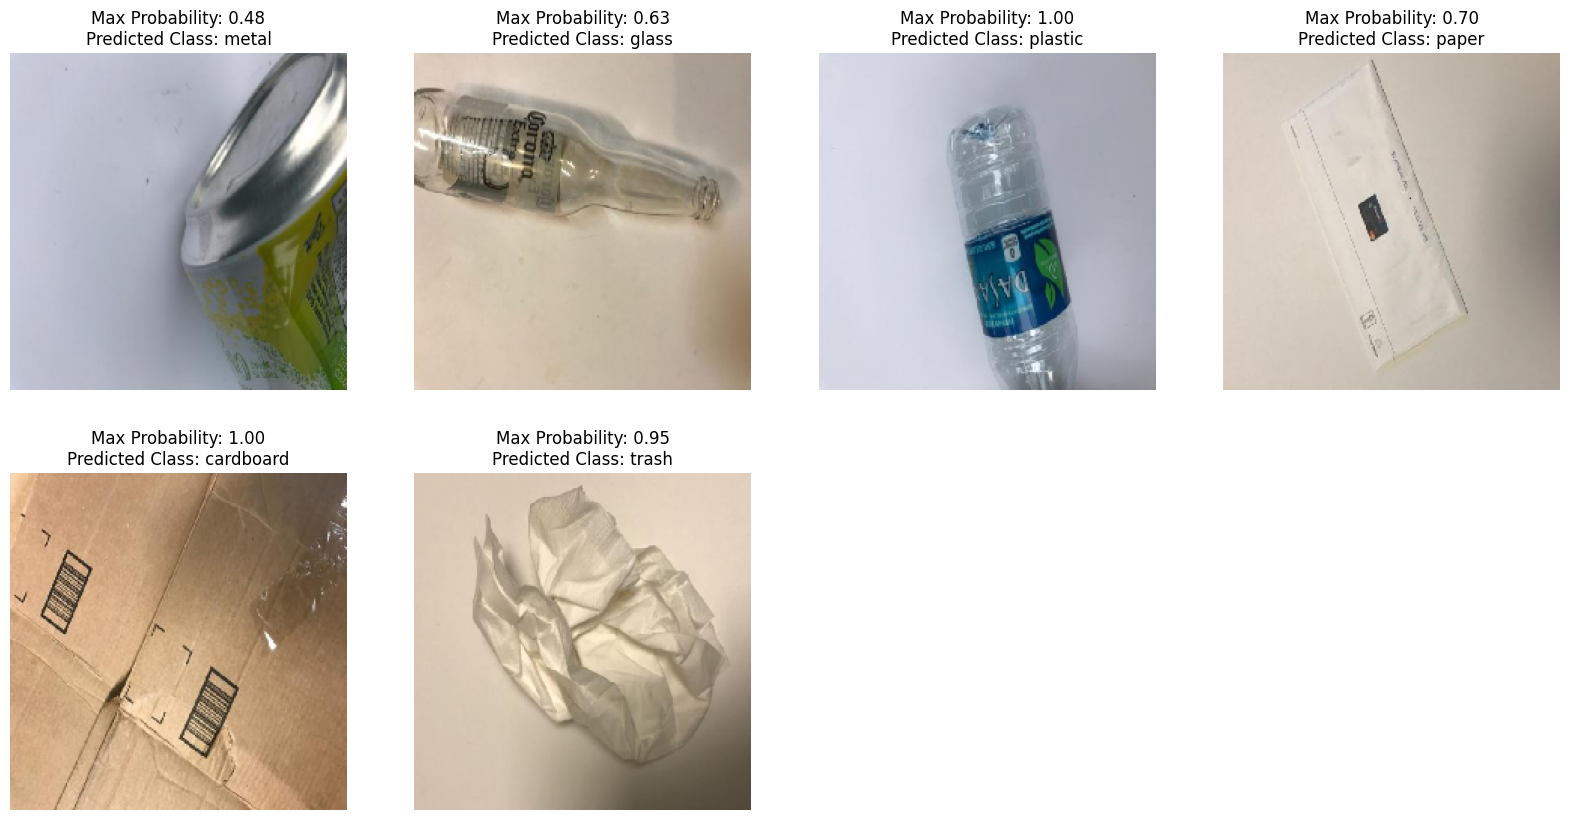

In [33]:
display_images(images_paths, garbage_model, waste_labels)

In [34]:
get_image_paths(im_dir, 10)

['/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/paper/paper267.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/glass/glass13.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/trash/trash82.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/cardboard/cardboard9.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/glass/glass82.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/cardboard/cardboard234.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/plastic/plastic241.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classification/glass/glass193.jpg',
 '/content/drive/MyDrive/04_cnn_course_materials/datasets_and_files/Garbage classificatio

In [36]:
random_images_path = get_image_paths(im_dir, 10)

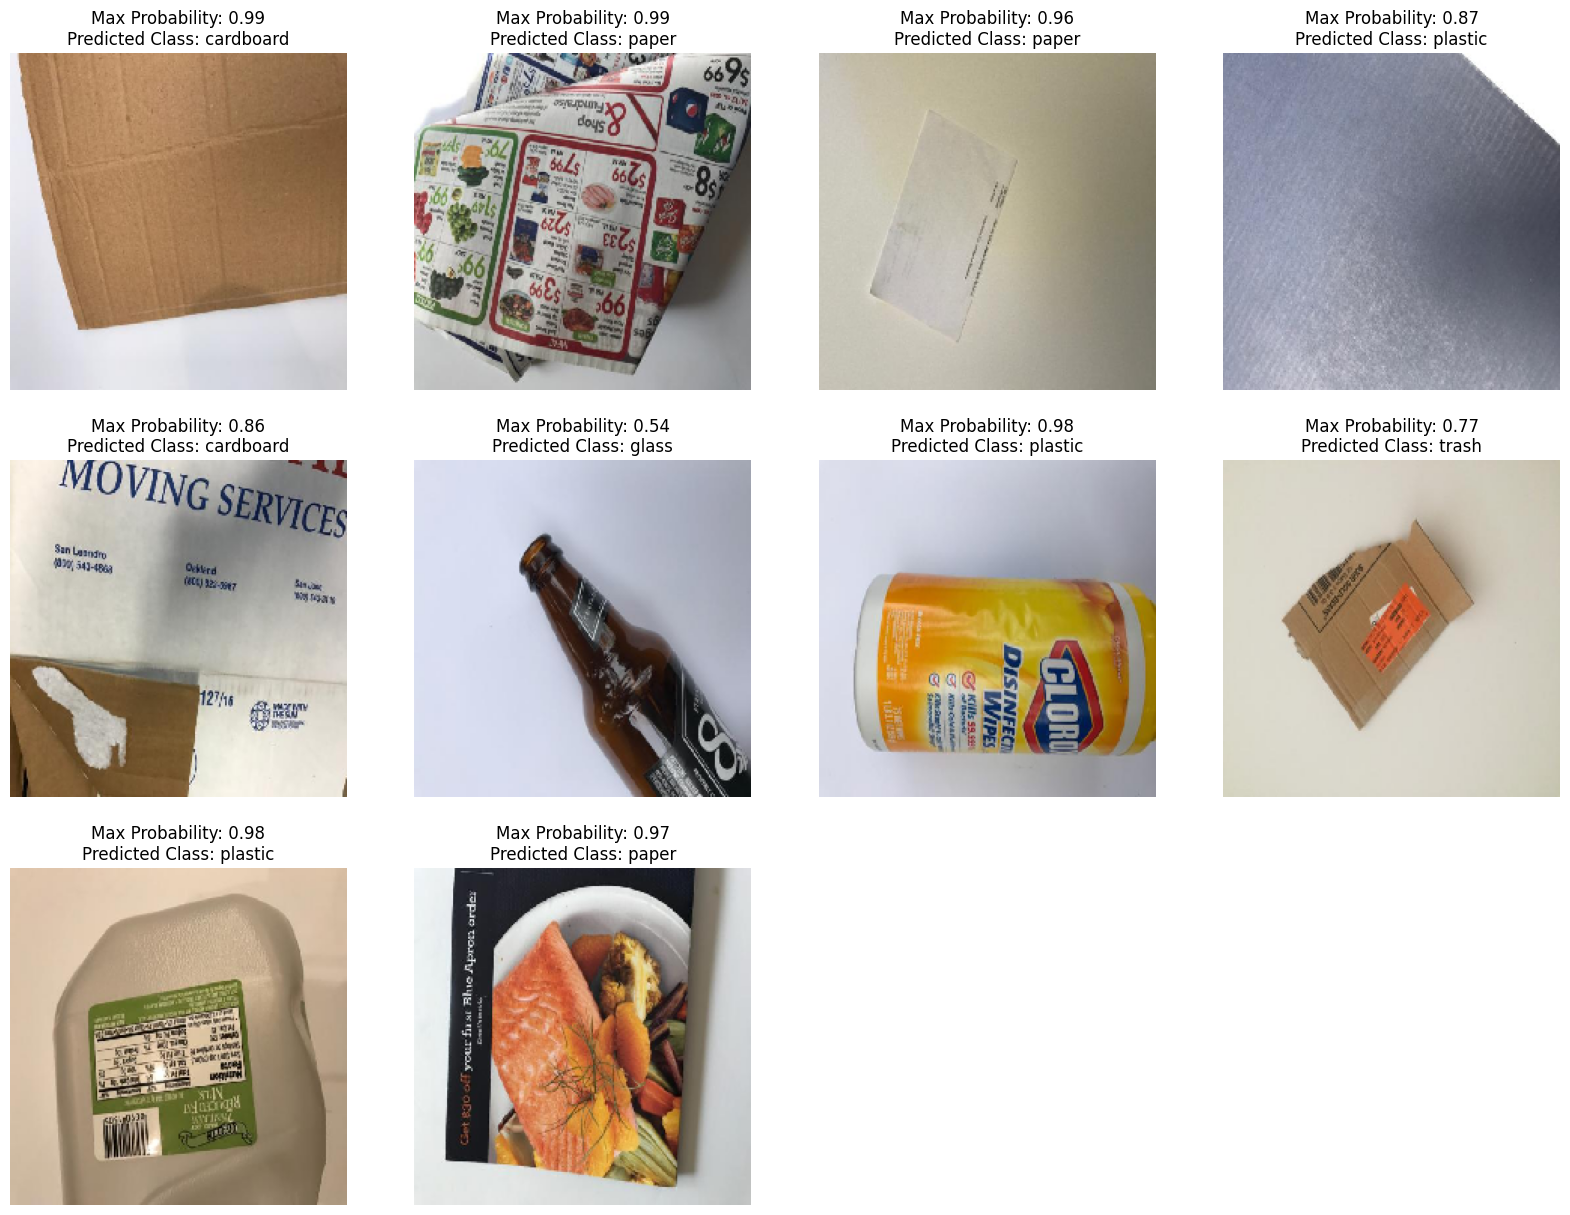

In [37]:
display_images(random_images_path, garbage_model, waste_labels)